# Biomarker detection in OLIVES using pretrained Models


### Step 1: Import data
Consistent for all models. Only change output size!

In [8]:
import os
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# set the size of the image according to your model needs
imageSize = 224 # ResNet works with 224x224 pixels

# Custom Dataset
class BiomarkerDataset(Dataset):
    def __init__(self, label_file, transform=None, num_frames=0):
        """
        Args:
            label_file (str): Path to the CSV file.
            transform (callable, optional): Transform to be applied on a sample.
            num_frames (int): Number of adjacent frames to use in the input sequence (1 adjacent frame -> 3 consecutive images).
        """
        self.data = pd.read_csv(label_file)
        self.transform = transform
        self.num_frames = num_frames
        
        # Exclude indices which don't have enough adjacent images
        self.valid_indices = self.data[(self.data.iloc[:, 1] > num_frames) & (self.data.iloc[:, 1] < (50-num_frames))].index.tolist()

    def __len__(self):
        # we can't use the length of the data since we have to exclude the first and last image (for num_frames=1) of each OCT scan
        return len(self.valid_indices)

    def __getitem__(self, idx):
        
        # Base path
        img_base_path = '/storage/ice1/shared/d-pace_community/makerspace-datasets/MEDICAL/OLIVES/OLIVES'
        
        # Get the actual data index
        index = self.valid_indices[idx]
        
        # Initialize
        images = []
        
        # Load a sequence of consecutive images
        for i in range(index - self.num_frames, index + self.num_frames +1):
            img_path = img_base_path + self.data.iloc[i, 0]
            img = Image.open(img_path).convert("L") # 'L' is for grayscale; can be removed!?
            
            if self.transform is not None:
                # apply data transformations (transforms it to tensor)
                img = self.transform(img)
            
            # stack torch tensor
            img = img.squeeze(0)  # Removes the first dimension if it's 1
            images.append(img)
        
        # Stack the 3 grayscale images along the channel dimension
        # Resulting tensor shape will be [3, H, W]
        images = torch.stack(images, dim=0)
        # print(images.shape) # debugging
        
        # Biomarker columns
        labels = torch.tensor(self.data.iloc[index, 2:18].astype(float), dtype=torch.float32)
        
        # Get clinical data:
        eye_id = self.data.iloc[index, 18]
        bcva = self.data.iloc[index, 19]
        cst = self.data.iloc[index, 20]
        patient_id = self.data.iloc[index, 21]

        # Convert clinical data to tensor
        clinical_data = torch.tensor([eye_id, bcva, cst, patient_id], dtype=torch.float32)
        
        return images, labels, clinical_data
    
    
# Define transformers

# Values for normalization taken from example paper
mean = 0.1706
std = 0.2112

# train with data augmentation
train_transformer = transforms.Compose([
    # WORSE PERFORMANCE # transforms.RandomPerspective(distortion_scale=0.1, p=0.5, fill=0),  # Add perspective shift
    # WORSE PERFORMANCE # transforms.RandomResizedCrop(size=imageSize, scale=(0.9, 1.0)), # RandomCrop between 70% to 100% of original size
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color properties
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(degrees=10, fill=0),  # Rotates randomly between + and - degree and fills new pixels with black
    transforms.Resize(imageSize), # Resize to models needs
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean, std) # we have to calculate these values for our dataset
])
# train without data augmentation
test_transformer = transforms.Compose([   
    transforms.Resize(imageSize), # Resize to models needs
    transforms.CenterCrop(imageSize), # shouldn't do anything
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])



# set up train loader (just example since cross validation uses new ones)
train_dataset = BiomarkerDataset(label_file='OLIVES_Dataset_Labels/BiomarkerLabel_train_data.csv', transform=train_transformer, num_frames=1)
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, drop_last=True, pin_memory=True)

# set up test loader (this one actually is being used)
test_dataset = BiomarkerDataset(label_file='OLIVES_Dataset_Labels/BiomarkerLabel_train_data.csv', transform=test_transformer, num_frames=1)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=32, pin_memory=True)


### Step 2: Train model
First we initialize our model as well as some training parameters.

In [2]:
## --- Settings ---
num_epochs=35
batch_size=64
num_workers=32 # need this amount of CPUs for parallel data loading
k_folds=5
patience=7  # Number of epochs to wait for improvement

# get to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## ---- Fusion model ----
class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        
        # Image feature extractor
        self.image_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.image_model.fc = nn.Linear(self.image_model.fc.in_features, 16)  # Adapt it to the given task (update final layer)
        # Load the saved model weights
        self.image_model.load_state_dict(torch.load('TrainedModels/ResNet50/ResNet50_f1weighted0.9504_k5_e35_p7_weights.pth', weights_only=True))
        # Freeze the weights so they are not updated during training
        for param in self.image_model.parameters():
            param.requires_grad = False
        
        # Fully connected layers for clinical data (BCVA, CST, Patient ID, Eye ID)
        self.clinical_fc = nn.Sequential(
            nn.Linear(4, 64),  # 4 input features
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Combine image features (16) and clinical features (64)
        self.fusion_fc = nn.Sequential(
            nn.Linear(16 + 64, 128),  # 16 from ImageModel + 64 from clinical data
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 16)  # 16 output biomarkers
        )
    
    def forward(self, image, clinical_data):
              
        # Pass the image through ImageModel
        image_features = self.image_model(image)
                
        # Pass clinical data through the fully connected layer
        clinical_features = self.clinical_fc(clinical_data)
        
        # Concatenate image and clinical features
        combined_features = torch.cat([image_features, clinical_features], dim=1)
        
        # Final fully connected layer to predict biomarkers
        output = self.fusion_fc(combined_features)
        
        return output
    
# Create the model
model = FusionModel().to(device)
model.name = "FusionModel_ResNet50"

# Loss function, optimizer nad Learning rate sheduler
loss_fn = nn.BCEWithLogitsLoss()  # For multi-label classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.9) # NOT GOOD: This set every f1 score to 0!!
    # weight decay to reduce overfitting 
scheduler = ExponentialLR(optimizer, gamma=0.9)

# Creates all needed folders to store the model weights if they don't exist already
os.makedirs("ModelWeights_TempSaves", exist_ok=True)
os.makedirs(f"TrainedModels/{model.name}", exist_ok=True)



Now we go over to the training process where we do a cross-validation.

In [3]:
# --- Train/Test Loops ---
# Training loop
def train_loop(model, train_loader, optimizer, loss_fn, device):
    # Set model to train mode
    model.train()
    
    # Initialize
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    # for images, labels, _ in train_loader:
    for images, labels, clinical_data in tqdm(train_loader, desc="Training"):
        # shift to cuda
        images = images.to(device)
        labels = labels.to(device)
        clinical_data = clinical_data.to(device)
        
        # Zero the parameter gradients 
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images, clinical_data)
        loss = loss_fn(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track predictions and labels for metrics calculation
        running_loss += loss.item() * images.size(0)
        all_preds.append(outputs)
        all_labels.append(labels)
    
    # Average loss
    avg_loss = running_loss / len(train_loader.dataset)
    
    return avg_loss

# test loop
def test_loop(model, test_loader, loss_fn, device):
    # Set model to evaluation mode
    model.eval()
    
    # Initialize
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels, clinical_data in test_loader:
        # for images, labels, _ in tqdm(val_loader, desc="Validating"):
            # Store labels since they won't be altered
            # all_labels.append(labels.numpy())
            
            # Shift to cuda
            images = images.to(device)
            labels = labels.to(device)
            clinical_data = clinical_data.to(device)
        
            # Forward pass
            outputs = model(images, clinical_data)
            
            # Get metrics
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * images.size(0)
            
            # Sigmoid activation to get probabilities, then threshold at 0.5 for binary classification
            preds = torch.sigmoid(outputs) > 0.5 
            # preds = (torch.sigmoid(outputs) > 0.5).int()  # Apply sigmoid and threshold at 0.5

            # Store (numpy for easier processing later)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Calculate average loss
    avg_loss = running_loss / len(test_loader.dataset)

    # Convert lists of predictions and labels into a 2D array where each row is a sample, each column is a biomarker
    all_preds = np.concatenate(all_preds, axis=0)  # Shape: (num_samples, num_biomarkers)
    all_labels = np.concatenate(all_labels, axis=0)  # Shape: (num_samples, num_biomarkers)
    
    # Calculate F1 score for each biomarker (column) independently
#     f1_scores = []
#     for i in range(all_labels.shape[1]):  # Iterate over each biomarker
#         f1 = f1_score(all_labels[:, i], all_preds[:, i], average='binary')  # Compute F1 score for the ith biomarker
#         f1_scores.append(f1)

    # Average loss
    val_loss = running_loss / len(test_loader.dataset)
    # return val_loss, f1_scores, all_preds, all_labels
    return val_loss, all_preds, all_labels


# --- Cross-Validation ---

# Initialize object to split dataset in kfold
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=0)

fold_metrics = []
    
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f"Fold {fold+1}/{k_folds}")

    # Split the training dataset into training and validation folds
    train_fold = Subset(train_dataset, train_idx)
    val_fold = Subset(train_dataset, val_idx)
    
    # Set up Dataloaders
    train_loader = DataLoader(train_fold, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_fold, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    # Reset parameters
    best_val_loss = float('inf')
    best_val_f1 = 0.0
    counter_NoImprovement = 0

    for epoch in range(num_epochs):
    # for epoch in tqdm(range(num_epochs), desc="Training Epochs", unit="epoch"):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train the model for one epoch
        train_loss = train_loop(model, train_loader, optimizer, loss_fn, device)
        print(f"Train Loss: {train_loss:.4f}")

        # Validate the model after training using validation fold
        val_loss, all_preds, all_labels = test_loop(model, val_loader, loss_fn, device)
        val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        print(f"Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}")
        
        # Update learning rate
        scheduler.step()
        
        # Early stopping logic: Check if F1 improved
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            no_improvement = 0  # Reset counter
            torch.save(model.state_dict(), f"ModelWeights_TempSaves/best_{model.name}_fold_{fold+1}.pth")
        else:
            no_improvement += 1

        # Stop training if no improvement for 'patience' epochs
        if no_improvement >= patience:
            print("Early stopping triggered.")
            break
        
#         # Save the best model based on validation loss
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save(model.state_dict(), f"ModelWeights_TempSaves/best_{model.name}_fold_{fold+1}.pth")

    # Load the weights of the model with the best validationg loss
    model.load_state_dict(torch.load(f"ModelWeights_TempSaves/best_{model.name}_fold_{fold+1}.pth", weights_only=True))
 
    # Get Accuracy
    # preds = (torch.sigmoid(torch.tensor(all_preds)) > 0.5).int()  # Apply sigmoid and threshold at 0.5
    val_accuracy = accuracy_score(all_labels, all_preds)
    fold_metrics.append(val_accuracy)
    print(f"Validation Accuracy for Fold {fold+1}: {val_accuracy:.4f}")

avg_accuracy = np.mean(fold_metrics)
print(f"\nAverage Accuracy over all folds: {avg_accuracy:.4f}")


Fold 1/5
Epoch 1/30


Training: 100%|██████████| 90/90 [00:04<00:00, 19.10it/s]

Train Loss: 6.8614


Validation Loss: 0.8162, Validation F1: 0.4518
Epoch 2/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.54it/s]

Train Loss: 3.2556


Validation Loss: 0.8050, Validation F1: 0.4604
Epoch 3/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.38it/s]

Train Loss: 2.4724


Validation Loss: 0.6480, Validation F1: 0.4673
Epoch 4/30


Training: 100%|██████████| 90/90 [00:04<00:00, 21.82it/s]

Train Loss: 1.9941


Validation Loss: 0.5297, Validation F1: 0.4810
Epoch 5/30


Training: 100%|██████████| 90/90 [00:04<00:00, 21.81it/s]

Train Loss: 1.7025


Validation Loss: 0.4433, Validation F1: 0.4901
Epoch 6/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.93it/s]

Train Loss: 1.4445


Validation Loss: 0.3989, Validation F1: 0.4636
Epoch 7/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.26it/s]

Train Loss: 1.2597


Validation Loss: 0.3698, Validation F1: 0.4411
Epoch 8/30


Training: 100%|██████████| 90/90 [00:04<00:00, 21.85it/s]

Train Loss: 1.1111


Validation Loss: 0.3406, Validation F1: 0.4433
Epoch 9/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.48it/s]

Train Loss: 1.0220


Validation Loss: 0.3254, Validation F1: 0.4261
Epoch 10/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.19it/s]

Train Loss: 0.9289


Validation Loss: 0.3179, Validation F1: 0.4214
Epoch 11/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.06it/s]

Train Loss: 0.8486


Validation Loss: 0.3145, Validation F1: 0.4574
Epoch 12/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.12it/s]

Train Loss: 0.7987


Validation Loss: 0.3126, Validation F1: 0.4489
Epoch 13/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.88it/s]

Train Loss: 0.7439


Validation Loss: 0.3109, Validation F1: 0.4011
Epoch 14/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.87it/s]

Train Loss: 0.7175


Validation Loss: 0.3103, Validation F1: 0.3964
Epoch 15/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.57it/s]

Train Loss: 0.6843


Validation Loss: 0.3094, Validation F1: 0.3861
Epoch 16/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.03it/s]

Train Loss: 0.6526


Validation Loss: 0.3087, Validation F1: 0.3692
Epoch 17/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.33it/s]

Train Loss: 0.6343


Validation Loss: 0.3092, Validation F1: 0.3480
Epoch 18/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.03it/s]

Train Loss: 0.6080


Validation Loss: 0.3092, Validation F1: 0.3375
Epoch 19/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.18it/s]

Train Loss: 0.5975


Validation Loss: 0.3087, Validation F1: 0.3347
Epoch 20/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.69it/s]

Train Loss: 0.5798


Validation Loss: 0.3084, Validation F1: 0.3325
Epoch 21/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.34it/s]

Train Loss: 0.5630


Validation Loss: 0.3085, Validation F1: 0.3291
Epoch 22/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.47it/s]

Train Loss: 0.5598


Validation Loss: 0.3078, Validation F1: 0.3350
Epoch 23/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.36it/s]

Train Loss: 0.5514


Validation Loss: 0.3076, Validation F1: 0.3500
Epoch 24/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.21it/s]

Train Loss: 0.5467


Validation Loss: 0.3076, Validation F1: 0.3563
Epoch 25/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.10it/s]

Train Loss: 0.5326


Validation Loss: 0.3078, Validation F1: 0.3666
Early stopping triggered.
Validation Accuracy for Fold 1: 0.0469
Fold 2/5
Epoch 1/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.43it/s]

Train Loss: 1.5283


Validation Loss: 0.4165, Validation F1: 0.4799
Epoch 2/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.57it/s]

Train Loss: 1.4513


Validation Loss: 0.4073, Validation F1: 0.4677
Epoch 3/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.38it/s]

Train Loss: 1.4364


Validation Loss: 0.3991, Validation F1: 0.4637
Epoch 4/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.97it/s]

Train Loss: 1.3716


Validation Loss: 0.3904, Validation F1: 0.4574
Epoch 5/30


Training: 100%|██████████| 90/90 [00:04<00:00, 21.42it/s]

Train Loss: 1.3309


Validation Loss: 0.3840, Validation F1: 0.4471
Epoch 6/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.10it/s]

Train Loss: 1.3166


Validation Loss: 0.3768, Validation F1: 0.4488
Epoch 7/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.47it/s]

Train Loss: 1.2864


Validation Loss: 0.3728, Validation F1: 0.4445
Epoch 8/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.62it/s]

Train Loss: 1.2566


Validation Loss: 0.3676, Validation F1: 0.4468
Epoch 9/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.72it/s]

Train Loss: 1.2520


Validation Loss: 0.3655, Validation F1: 0.4397
Epoch 10/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.02it/s]

Train Loss: 1.2185


Validation Loss: 0.3625, Validation F1: 0.4370
Epoch 11/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.50it/s]

Train Loss: 1.1986


Validation Loss: 0.3600, Validation F1: 0.4370
Epoch 12/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.24it/s]

Train Loss: 1.1881


Validation Loss: 0.3581, Validation F1: 0.4326
Epoch 13/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.84it/s]

Train Loss: 1.1759


Validation Loss: 0.3557, Validation F1: 0.4361
Epoch 14/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.88it/s]

Train Loss: 1.1811


Validation Loss: 0.3539, Validation F1: 0.4366
Epoch 15/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.00it/s]

Train Loss: 1.1687


Validation Loss: 0.3519, Validation F1: 0.4325
Epoch 16/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.21it/s]

Train Loss: 1.1614


Validation Loss: 0.3510, Validation F1: 0.4286
Epoch 17/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.40it/s]

Train Loss: 1.1457


Validation Loss: 0.3491, Validation F1: 0.4322
Epoch 18/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.25it/s]

Train Loss: 1.1345


Validation Loss: 0.3478, Validation F1: 0.4289
Epoch 19/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.66it/s]

Train Loss: 1.1476


Validation Loss: 0.3466, Validation F1: 0.4293
Epoch 20/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.19it/s]

Train Loss: 1.1401


Validation Loss: 0.3460, Validation F1: 0.4300
Epoch 21/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.44it/s]

Train Loss: 1.1317


Validation Loss: 0.3452, Validation F1: 0.4257
Early stopping triggered.
Validation Accuracy for Fold 2: 0.0875
Fold 3/5
Epoch 1/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.58it/s]

Train Loss: 1.4752


Validation Loss: 0.4434, Validation F1: 0.4745
Epoch 2/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.88it/s]

Train Loss: 1.4676


Validation Loss: 0.4420, Validation F1: 0.4739
Epoch 3/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.30it/s]

Train Loss: 1.4831


Validation Loss: 0.4421, Validation F1: 0.4714
Epoch 4/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.25it/s]

Train Loss: 1.4410


Validation Loss: 0.4404, Validation F1: 0.4730
Epoch 5/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.30it/s]

Train Loss: 1.4685


Validation Loss: 0.4402, Validation F1: 0.4717
Epoch 6/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.81it/s]

Train Loss: 1.4742


Validation Loss: 0.4396, Validation F1: 0.4690
Epoch 7/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.53it/s]

Train Loss: 1.4738


Validation Loss: 0.4398, Validation F1: 0.4680
Epoch 8/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.37it/s]

Train Loss: 1.4597


Validation Loss: 0.4400, Validation F1: 0.4666
Epoch 9/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.77it/s]

Train Loss: 1.4384


Validation Loss: 0.4390, Validation F1: 0.4678
Epoch 10/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.64it/s]

Train Loss: 1.4510


Validation Loss: 0.4391, Validation F1: 0.4668
Epoch 11/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.24it/s]

Train Loss: 1.4165


Validation Loss: 0.4375, Validation F1: 0.4674
Epoch 12/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.11it/s]

Train Loss: 1.4324


Validation Loss: 0.4374, Validation F1: 0.4660
Epoch 13/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.90it/s]

Train Loss: 1.4340


Validation Loss: 0.4379, Validation F1: 0.4659
Epoch 14/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.15it/s]

Train Loss: 1.4302


Validation Loss: 0.4377, Validation F1: 0.4651
Epoch 15/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.00it/s]

Train Loss: 1.4272


Validation Loss: 0.4374, Validation F1: 0.4669
Epoch 16/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.60it/s]

Train Loss: 1.4092


Validation Loss: 0.4366, Validation F1: 0.4688
Epoch 17/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.55it/s]

Train Loss: 1.4233


Validation Loss: 0.4371, Validation F1: 0.4666
Epoch 18/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.20it/s]

Train Loss: 1.4389


Validation Loss: 0.4369, Validation F1: 0.4657
Epoch 19/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.21it/s]

Train Loss: 1.4386


Validation Loss: 0.4364, Validation F1: 0.4678
Epoch 20/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.28it/s]

Train Loss: 1.4326


Validation Loss: 0.4368, Validation F1: 0.4647
Epoch 21/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.11it/s]

Train Loss: 1.4345


Validation Loss: 0.4358, Validation F1: 0.4662
Early stopping triggered.
Validation Accuracy for Fold 3: 0.0861
Fold 4/5
Epoch 1/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.94it/s]

Train Loss: 1.4938


Validation Loss: 0.4293, Validation F1: 0.4924
Epoch 2/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.16it/s]

Train Loss: 1.4727


Validation Loss: 0.4296, Validation F1: 0.4912
Epoch 3/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.19it/s]

Train Loss: 1.4775


Validation Loss: 0.4293, Validation F1: 0.4897
Epoch 4/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.65it/s]

Train Loss: 1.4680


Validation Loss: 0.4294, Validation F1: 0.4905
Epoch 5/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.90it/s]

Train Loss: 1.4799


Validation Loss: 0.4296, Validation F1: 0.4907
Epoch 6/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.88it/s]

Train Loss: 1.4957


Validation Loss: 0.4284, Validation F1: 0.4929
Epoch 7/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.51it/s]

Train Loss: 1.4895


Validation Loss: 0.4291, Validation F1: 0.4886
Epoch 8/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.50it/s]

Train Loss: 1.4938


Validation Loss: 0.4289, Validation F1: 0.4905
Epoch 9/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.81it/s]

Train Loss: 1.4793


Validation Loss: 0.4289, Validation F1: 0.4913
Epoch 10/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.82it/s]

Train Loss: 1.4741


Validation Loss: 0.4295, Validation F1: 0.4890
Epoch 11/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.09it/s]

Train Loss: 1.4914


Validation Loss: 0.4292, Validation F1: 0.4917
Epoch 12/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.16it/s]

Train Loss: 1.5052


Validation Loss: 0.4287, Validation F1: 0.4929
Epoch 13/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.79it/s]

Train Loss: 1.4638


Validation Loss: 0.4289, Validation F1: 0.4900
Epoch 14/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.93it/s]

Train Loss: 1.4821


Validation Loss: 0.4291, Validation F1: 0.4866
Epoch 15/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.77it/s]

Train Loss: 1.4886


Validation Loss: 0.4282, Validation F1: 0.4919
Epoch 16/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.44it/s]

Train Loss: 1.4802


Validation Loss: 0.4286, Validation F1: 0.4917
Epoch 17/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.99it/s]

Train Loss: 1.5018


Validation Loss: 0.4294, Validation F1: 0.4889
Epoch 18/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.90it/s]

Train Loss: 1.4802


Validation Loss: 0.4290, Validation F1: 0.4903
Epoch 19/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.09it/s]

Train Loss: 1.4939


Validation Loss: 0.4290, Validation F1: 0.4904
Epoch 20/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.70it/s]

Train Loss: 1.4648


Validation Loss: 0.4289, Validation F1: 0.4929
Epoch 21/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.81it/s]

Train Loss: 1.4727


Validation Loss: 0.4288, Validation F1: 0.4892
Epoch 22/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.43it/s]

Train Loss: 1.4848


Validation Loss: 0.4281, Validation F1: 0.4917
Epoch 23/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.66it/s]

Train Loss: 1.4912


Validation Loss: 0.4285, Validation F1: 0.4903
Epoch 24/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.84it/s]

Train Loss: 1.4677


Validation Loss: 0.4287, Validation F1: 0.4893
Epoch 25/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.00it/s]


Train Loss: 1.4596
Validation Loss: 0.4287, Validation F1: 0.4890
Epoch 26/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.45it/s]

Train Loss: 1.4813


Validation Loss: 0.4283, Validation F1: 0.4924
Epoch 27/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.51it/s]

Train Loss: 1.4825


Validation Loss: 0.4286, Validation F1: 0.4908
Epoch 28/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.38it/s]

Train Loss: 1.4739


Validation Loss: 0.4288, Validation F1: 0.4929
Epoch 29/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.62it/s]

Train Loss: 1.4708


Validation Loss: 0.4292, Validation F1: 0.4896
Epoch 30/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.47it/s]

Train Loss: 1.5054


Validation Loss: 0.4288, Validation F1: 0.4895
Validation Accuracy for Fold 4: 0.1099
Fold 5/5
Epoch 1/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.16it/s]

Train Loss: 1.4559


Validation Loss: 0.4286, Validation F1: 0.4817
Epoch 2/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.81it/s]

Train Loss: 1.4874


Validation Loss: 0.4281, Validation F1: 0.4818
Epoch 3/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.66it/s]

Train Loss: 1.4777


Validation Loss: 0.4278, Validation F1: 0.4800
Epoch 4/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.52it/s]

Train Loss: 1.4525


Validation Loss: 0.4287, Validation F1: 0.4831
Epoch 5/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.47it/s]

Train Loss: 1.4888


Validation Loss: 0.4276, Validation F1: 0.4832
Epoch 6/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.10it/s]

Train Loss: 1.4735


Validation Loss: 0.4272, Validation F1: 0.4841
Epoch 7/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.64it/s]

Train Loss: 1.4909


Validation Loss: 0.4280, Validation F1: 0.4825
Epoch 8/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.99it/s]

Train Loss: 1.4675


Validation Loss: 0.4284, Validation F1: 0.4822
Epoch 9/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.41it/s]

Train Loss: 1.4702


Validation Loss: 0.4280, Validation F1: 0.4833
Epoch 10/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.75it/s]

Train Loss: 1.4810


Validation Loss: 0.4283, Validation F1: 0.4821
Epoch 11/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.10it/s]

Train Loss: 1.4826


Validation Loss: 0.4277, Validation F1: 0.4837
Epoch 12/30


Training: 100%|██████████| 90/90 [00:04<00:00, 21.62it/s]

Train Loss: 1.4786


Validation Loss: 0.4279, Validation F1: 0.4807
Epoch 13/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.06it/s]

Train Loss: 1.4879


Validation Loss: 0.4278, Validation F1: 0.4841
Epoch 14/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.17it/s]

Train Loss: 1.4581


Validation Loss: 0.4285, Validation F1: 0.4828
Epoch 15/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.25it/s]

Train Loss: 1.4892


Validation Loss: 0.4286, Validation F1: 0.4811
Epoch 16/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.17it/s]

Train Loss: 1.4732


Validation Loss: 0.4275, Validation F1: 0.4824
Epoch 17/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.13it/s]

Train Loss: 1.4715


Validation Loss: 0.4275, Validation F1: 0.4814
Epoch 18/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.36it/s]

Train Loss: 1.4857


Validation Loss: 0.4283, Validation F1: 0.4820
Epoch 19/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.75it/s]

Train Loss: 1.5010


Validation Loss: 0.4282, Validation F1: 0.4864
Epoch 20/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.43it/s]

Train Loss: 1.4602


Validation Loss: 0.4277, Validation F1: 0.4820
Epoch 21/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.95it/s]

Train Loss: 1.4714


Validation Loss: 0.4280, Validation F1: 0.4831
Epoch 22/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.90it/s]

Train Loss: 1.4815


Validation Loss: 0.4281, Validation F1: 0.4802
Epoch 23/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.00it/s]

Train Loss: 1.4522


Validation Loss: 0.4285, Validation F1: 0.4812
Epoch 24/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.71it/s]

Train Loss: 1.4803


Validation Loss: 0.4277, Validation F1: 0.4817
Epoch 25/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.27it/s]

Train Loss: 1.4653


Validation Loss: 0.4285, Validation F1: 0.4805
Epoch 26/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.38it/s]

Train Loss: 1.4657


Validation Loss: 0.4282, Validation F1: 0.4817
Epoch 27/30


Training: 100%|██████████| 90/90 [00:04<00:00, 22.30it/s]

Train Loss: 1.4836


Validation Loss: 0.4282, Validation F1: 0.4832
Epoch 28/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.19it/s]

Train Loss: 1.4952


Validation Loss: 0.4279, Validation F1: 0.4802
Epoch 29/30


Training: 100%|██████████| 90/90 [00:03<00:00, 23.48it/s]


Train Loss: 1.4797
Validation Loss: 0.4278, Validation F1: 0.4827
Epoch 30/30


Training: 100%|██████████| 90/90 [00:03<00:00, 22.82it/s]

Train Loss: 1.4744


Validation Loss: 0.4279, Validation F1: 0.4815
Validation Accuracy for Fold 5: 0.1092

Average Accuracy over all folds: 0.0879


Now Test

In [4]:
# ============================
# 5. Evaluation
# ============================

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating", unit="batch"):
            if not batch:  # Handle empty batches
                continue
            images, labels, clinical_data = batch
            images, labels, clinical_data = images.to(device), labels.to(device), clinical_data.to(device)
            outputs = model(images,clinical_data) # .logits
            y_true.append(labels.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    return y_true, y_pred

# Evaluate
y_true, y_pred = evaluate_model(model, testloader)

# Convert predicted probabilities to binary predictions
y_pred_binary = (sigmoid(y_pred) > 0.5).astype(int)
# y_pred_binary = (y_pred > 0.5).astype(int)

# Ensure `y_true` is binary
y_true_binary = (y_true > 0.5).astype(int)

# Metrics
report = classification_report(y_true_binary, y_pred_binary,zero_division=0)
report_data = classification_report(y_true_binary, y_pred_binary, output_dict=True,zero_division=0) # this is not clean to print but easier to extract
weighted_f1 = report_data['weighted avg']['f1-score']
samples_f1 = report_data['samples avg']['f1-score']
print("Classification Report:")
print(report)

# Store the predicitons in a csv file
# get the biomarker names
BiomarkerLabel_df = pd.read_csv('OLIVES_Dataset_Labels/BiomarkerLabel_train_data.csv')
biomarkers = BiomarkerLabel_df.columns[2:18] # Extract label columns names (biomarkers)

# Convert the predictions into a pandas DataFrame with biomarker names as columns
df_predictions = pd.DataFrame(y_pred_binary, columns=biomarkers)

# Add the "Index" name (as the row index)
df_predictions.insert(0, "Index", df_predictions.index.to_series().apply(lambda x: f"{x+1:04d}"))

# Save the DataFrame to a CSV file
df_predictions.to_csv("predictions_biomarkers.csv",  index=False)

Evaluating: 100%|██████████| 112/112 [00:02<00:00, 38.71batch/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.00      0.00      0.00       516
           2       0.00      0.00      0.00        29
           3       0.00      0.00      0.00       277
           4       0.68      0.94      0.78      4699
           5       0.76      0.43      0.55      2130
           6       0.66      0.70      0.68      4068
           7       0.00      0.00      0.00       677
           8       1.00      0.01      0.02      2102
           9       0.00      0.00      0.00         7
          10       0.87      0.19      0.32      2285
          11       0.89      0.29      0.44      3028
          12       0.00      0.00      0.00       180
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00        10
          15       0.00      0.00      0.00        57

   micro avg       0.70      0.47      0.56     20143
   

Save the trained model

In [5]:
# Save model weights to a file
torch.save(model.state_dict(), f"TrainedModels/{model.name}/{model.name}_f1weighted{weighted_f1:.4f}_k{k_folds}_e{num_epochs}_p{patience}_weights.pth")
# torch.save(model.state_dict(), f"TrainedModels/{model.name}/{model.name}_f1samples{samples_f1:.4f}_k{k_folds}_e{num_epochs}_p{patience}_weights.pth")

Even more evaluation

Evaluating Model with Clinical Data...
Evaluating Scan-Level Metrics...
Plotting Combined Confusion Matrix for Scan-Level Predictions...


<Figure size 600x400 with 0 Axes>

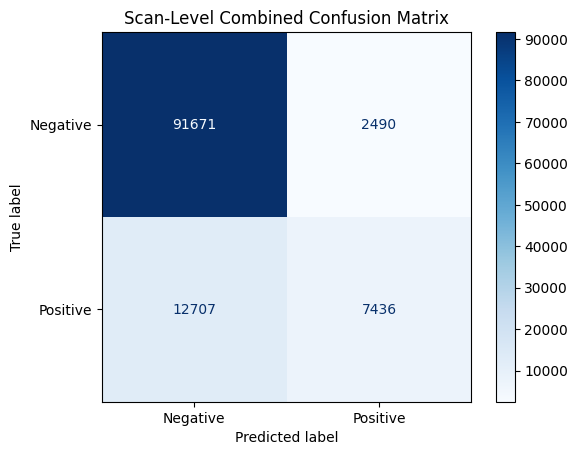

                           Biomarker       AUC  Precision    Recall        F1
0                            Atrophy  0.393289   0.000000  0.000000  0.000000
1                   Disruption of EZ  0.492474   0.000000  0.000000  0.000000
2                               DRIL  0.631963   0.000000  0.000000  0.000000
3                     IR hemorrhages  0.488576   0.000000  0.000000  0.000000
4                             IR HRF  0.707995   0.779759  0.716535  0.746812
5   Partially attached vitreous face  0.738887   0.937255  0.112207  0.200419
6       Fully attached vitreous face  0.725172   0.664572  0.701819  0.682688
7       Preretinal tissue/hemorrhage  0.418418   0.000000  0.000000  0.000000
8                    Vitreous debris  0.690010   0.000000  0.000000  0.000000
9                                VMT  0.628996   0.000000  0.000000  0.000000
10                            DRT/ME  0.791326   0.894879  0.145295  0.250000
11                       Fluid (IRF)  0.777453   0.937318  0.212

<Figure size 600x400 with 0 Axes>

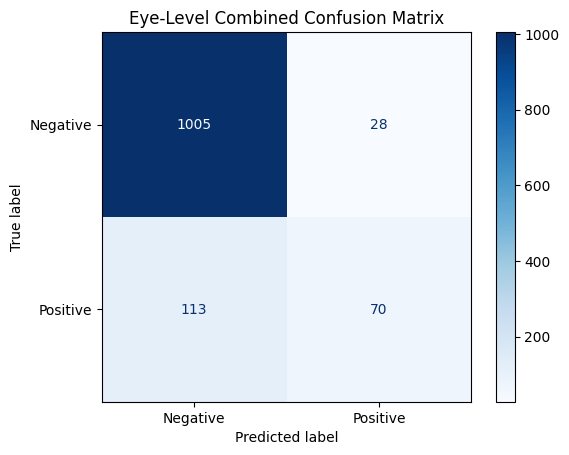

                           Biomarker       AUC  Precision    Recall        F1
0                            Atrophy       NaN   0.000000  0.000000  0.000000
1                   Disruption of EZ  0.093333   0.000000  0.000000  0.000000
2                               DRIL       NaN   0.000000  0.000000  0.000000
3                     IR hemorrhages  0.706667   0.000000  0.000000  0.000000
4                             IR HRF  0.650046   0.780000  0.684211  0.728972
5   Partially attached vitreous face  0.722992   1.000000  0.052632  0.100000
6       Fully attached vitreous face  0.736111   0.630435  0.725000  0.674419
7       Preretinal tissue/hemorrhage  0.305556   0.000000  0.000000  0.000000
8                    Vitreous debris  0.792627   0.000000  0.000000  0.000000
9                                VMT       NaN   0.000000  0.000000  0.000000
10                            DRT/ME  0.671984   0.000000  0.000000  0.000000
11                       Fluid (IRF)  0.697826   1.000000  0.033

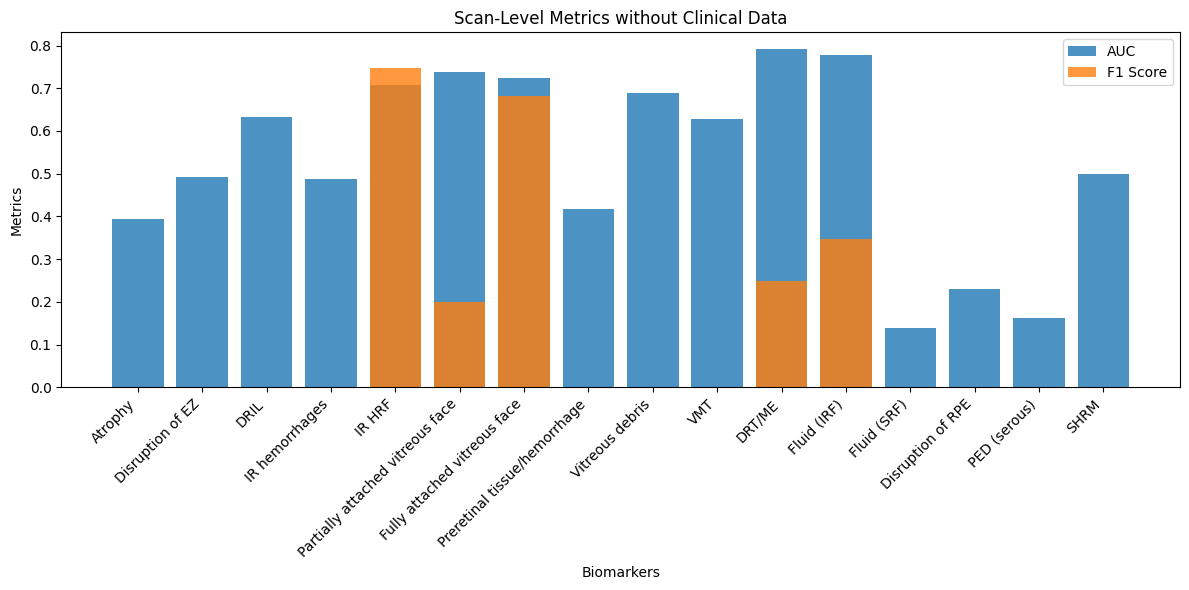

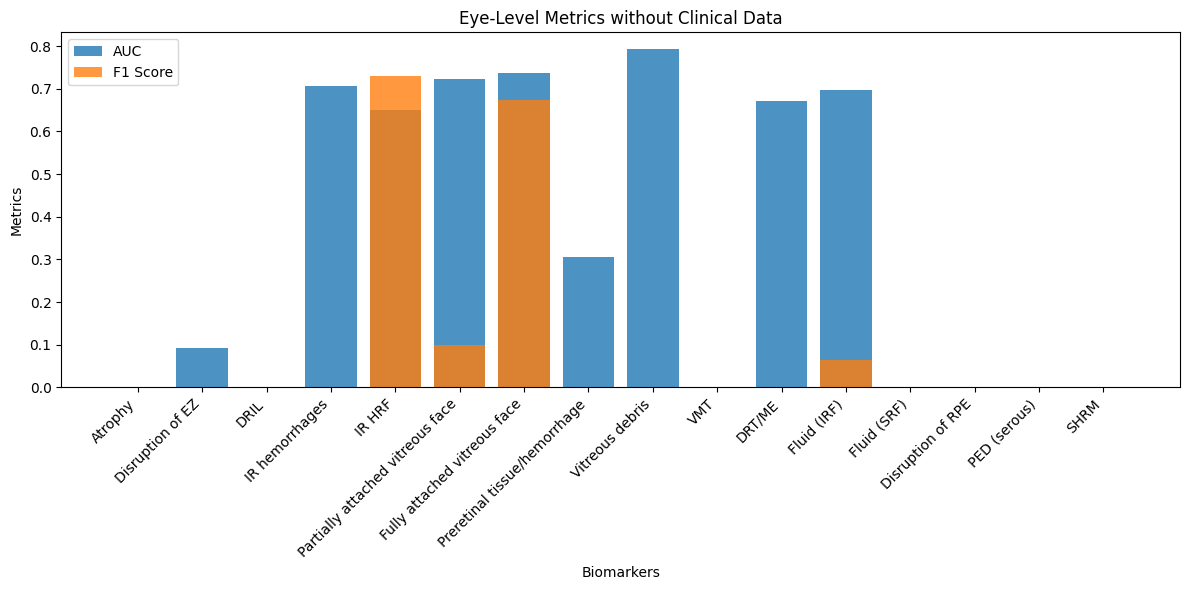


Ablation Study Results:
Clinical Data Impact on Biomarker Detection
                           Biomarker  F1 with Clinical Data
0                            Atrophy               0.000000
1                   Disruption of EZ               0.000000
2                               DRIL               0.000000
3                     IR hemorrhages               0.000000
4                             IR HRF               0.746812
5   Partially attached vitreous face               0.200419
6       Fully attached vitreous face               0.682688
7       Preretinal tissue/hemorrhage               0.000000
8                    Vitreous debris               0.000000
9                                VMT               0.000000
10                            DRT/ME               0.250000
11                       Fluid (IRF)               0.346257
12                       Fluid (SRF)               0.000000
13                 Disruption of RPE               0.000000
14                      PED (se

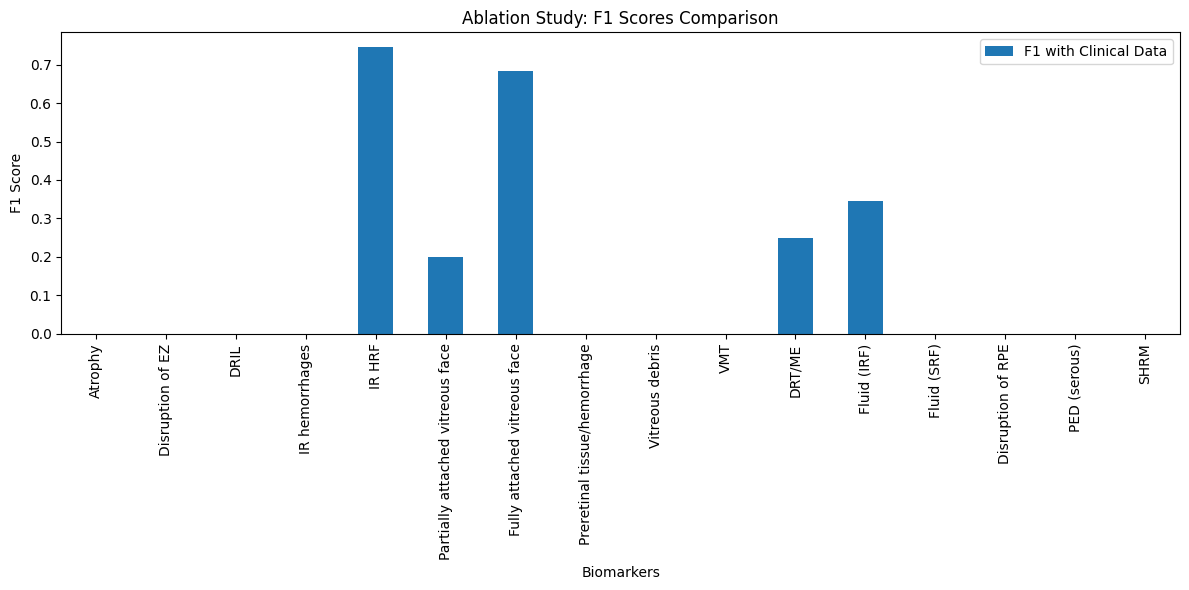

In [11]:
# Evaluation Function
def evaluate_model(model, loader, labels):
    """
    Evaluate the model and calculate metrics at the scan level.
    """
    model.eval()
    y_true, y_pred, eye_ids = [], [], []
    with torch.no_grad():
        for images, labels, clinical_data in loader:
            images, labels, clinical_data = (
                images.to(device),
                labels.to(device),
                clinical_data.to(device),
            )
            outputs = model(images,clinical_data)
            y_true.append(labels.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())
            if clinical_data.size(1) > 0:  # Ensure Eye_ID exists
                eye_ids.append(clinical_data[:, 0].cpu().numpy())
            else:
                eye_ids.append([])  # No Eye_ID if no clinical data
    return np.vstack(y_true), np.vstack(y_pred), np.concatenate(eye_ids)

# Aggregation Function for Eye-Level Metrics
def aggregate_by_eye(y_true, y_pred, eye_ids):
    """
    Aggregate predictions and labels at the eye level.
    """
    unique_eye_ids = np.unique(eye_ids)
    eye_level_true = []
    eye_level_pred = []
    for eye_id in unique_eye_ids:
        mask = eye_ids == eye_id
        eye_level_true.append(y_true[mask].mean(axis=0))
        eye_level_pred.append(y_pred[mask].mean(axis=0))
    return np.array(eye_level_true), np.array(eye_level_pred)

from sklearn.metrics import roc_auc_score, classification_report

def compute_metrics(y_true, y_pred, labels):
    """
    Compute classification metrics for each biomarker.
    Args:
        y_true (ndarray or Tensor): True labels.
        y_pred (ndarray or Tensor): Predicted probabilities.
        labels (list): Biomarker names.
    Returns:
        metrics_df (DataFrame): DataFrame with per-biomarker metrics.
    """
    # Ensure tensors are moved to CPU and converted to NumPy
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    # Threshold y_true to ensure binary values
    y_true = (y_true > 0.5).astype(int)

    num_biomarkers = min(len(labels), y_true.shape[1])
    metrics = {"Biomarker": [], "AUC": [], "Precision": [], "Recall": [], "F1": []}

    for i in range(num_biomarkers):
        label = labels[i]

        # Check if y_true contains both classes
        if len(np.unique(y_true[:, i])) < 2:
            # Skip AUC calculation for constant labels
            metrics["Biomarker"].append(label)
            metrics["AUC"].append(None)  # Undefined AUC
            metrics["Precision"].append(0.0)
            metrics["Recall"].append(0.0)
            metrics["F1"].append(0.0)
            continue

        # Calculate metrics
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        report = classification_report(
            y_true[:, i], (y_pred[:, i] > 0.5).astype(int), output_dict=True, zero_division=0
        )
        metrics["Biomarker"].append(label)
        metrics["AUC"].append(auc)
        metrics["Precision"].append(report["1"]["precision"])
        metrics["Recall"].append(report["1"]["recall"])
        metrics["F1"].append(report["1"]["f1-score"])
    return pd.DataFrame(metrics)

# Plotting Metrics
def plot_metrics(metrics_df, title):
    """
    Plot metrics as bar plots.
    """
    plt.figure(figsize=(12, 6))
    x = range(len(metrics_df))
    plt.bar(x, metrics_df["AUC"], label="AUC", alpha=0.8)
    plt.bar(x, metrics_df["F1"], label="F1 Score", alpha=0.8)
    plt.xticks(x, metrics_df["Biomarker"], rotation=45, ha="right")
    plt.xlabel("Biomarkers")
    plt.ylabel("Metrics")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

# Plot ROC-AUC Curves
def plot_roc_auc_curves(y_true, y_pred, labels):
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(labels):
        if len(np.unique(y_true[:, i])) < 2:
            continue  # Skip biomarkers with no positive samples
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f"{label} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC Curves")
    plt.legend()
    plt.show()


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Biomarker Labels
labels = [
    "Atrophy", "Disruption of EZ", "DRIL", "IR hemorrhages", "IR HRF",
    "Partially attached vitreous face", "Fully attached vitreous face",
    "Preretinal tissue/hemorrhage", "Vitreous debris", "VMT","DRT/ME", "Fluid (IRF)","Fluid (SRF)", "Disruption of RPE",
     "PED (serous)", "SHRM"
]

# Function to compute and plot a single confusion matrix for all biomarkers
def plot_combined_confusion_matrix(y_true, y_pred, title="Combined Confusion Matrix"):
    """
    Create and plot a single confusion matrix for all biomarkers.
    Args:
        y_true (ndarray): Ground truth binary labels for all biomarkers.
        y_pred (ndarray): Predicted probabilities for all biomarkers.
        title (str): Title for the confusion matrix plot.
    """
    # Flatten all biomarkers into a single dimension for combined confusion matrix
    y_true_combined = (y_true > 0.5).astype(int).ravel()  # Ensure binary labels
    y_pred_combined = (y_pred > 0.5).astype(int).ravel()  # Threshold predictions

    # Compute confusion matrix
    combined_matrix = confusion_matrix(y_true_combined, y_pred_combined)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=combined_matrix, display_labels=["Negative", "Positive"])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()


# Update the evaluation function to include combined confusion matrix
# Evaluate and Aggregate Results
def evaluate_with_eye_aggregation(model, loader, labels):
    """
    Evaluate model performance with and without eye-level aggregation.
    """
    print("Evaluating Scan-Level Metrics...")
    y_true, y_pred, eye_ids = evaluate_model(model, loader, labels)

    # Compute combined confusion matrix for scan-level predictions
    print("Plotting Combined Confusion Matrix for Scan-Level Predictions...")
    plot_combined_confusion_matrix(y_true, y_pred, "Scan-Level Combined Confusion Matrix")

    # Scan-Level Metrics
    scan_metrics = compute_metrics(y_true, y_pred, labels)
    print(scan_metrics)

    # Eye-Level Metrics
    eye_metrics = None
    if len(eye_ids) > 0:
        print("Evaluating Eye-Level Metrics...")
        eye_true, eye_pred = aggregate_by_eye(y_true, y_pred, eye_ids)

        # Compute combined confusion matrix for eye-level predictions
        print("Plotting Combined Confusion Matrix for Eye-Level Predictions...")
        plot_combined_confusion_matrix(eye_true, eye_pred, "Eye-Level Combined Confusion Matrix")

        eye_metrics = compute_metrics(eye_true, eye_pred, labels)
        print(eye_metrics)

    return scan_metrics, eye_metrics


# Evaluate Models


print("Evaluating Model with Clinical Data...")
scan_metrics_clinical, eye_metrics_clinical = evaluate_with_eye_aggregation(
    model, testloader, labels
)

# Plot Results
plot_metrics(scan_metrics_clinical, "Scan-Level Metrics without Clinical Data")
if eye_metrics_clinical is not None:
    plot_metrics(eye_metrics_clinical, "Eye-Level Metrics without Clinical Data")

# Ablation Study
print("\nAblation Study Results:")
print("Clinical Data Impact on Biomarker Detection")
comparison = pd.DataFrame({
    "Biomarker": labels,
    "F1 with Clinical Data": scan_metrics_clinical["F1"],
    # "F1 with Clinical Data": scan_metrics_no_clinical["F1"],
})
print(comparison)
comparison.plot(x="Biomarker", kind="bar", figsize=(12, 6), title="Ablation Study: F1 Scores Comparison")
plt.xlabel("Biomarkers")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()
